In [86]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import ifft, fftfreq, fftshift, fft
import scipy.io
import scipy.stats
import pandas as pd

def nan_interp(y):
    x = np.linspace(0, 1, len(y))
    ok = ~np.isnan(y)
    if np.sum(ok) == 0:
        return y
    return np.interp(x, x[ok], y[ok])
    
def nan_detrend(y):
    x = np.linspace(0, 1, len(y))
    ok = ~np.isnan(y)
    if np.sum(ok) == 0:
        return y
    m, b, _, _, _  = scipy.stats.linregress(x[ok], y[ok])
    return y - m*x - b

def cos_taper(a):
    x = np.linspace(-np.pi/2, np.pi/2, len(a))
    y = np.cos(x)
    tapered = y*a
    t_power = np.std(tapered)**2
    d_power = np.std(a)**2
    return tapered * np.sqrt(d_power/t_power)
    
def psd(a, dt, seg_time):
    # segmenting
    N = int(seg_time / dt)
    seg_indices = range(0, len(a) - N, int(N/2))
    seg_a = np.array([cos_taper(nan_interp(nan_detrend(a[i:i+N]))) for i in seg_indices])
    # Evaluate frequency info
    freq = fftshift(fftfreq(N, d=dt))
    # FFT
    F = fftshift(fft(seg_a, axis=1), axes=1)
    # Drop negative frequencies
    F = F[:,freq >= 0]
    freq = freq[freq >= 0]
    # Normalize
    Saa = (2*dt/N) * np.mean(np.abs(F)**2, axis=0)
    # Drop negative frequencies
    return Saa

In [35]:
rbr = xr.open_dataset('/home/cassandra/Willapa/2025-experiment-1/anchorRBRs/rbr.nc')

In [36]:
rbr

<xarray.Dataset> Size: 162MB
Dimensions:    (time: 1846390, location: 5)
Coordinates:
  * time       (time) datetime64[ns] 15MB 2025-06-16T23:36:39 ... 2025-06-27T...
  * location   (location) <U2 40B 'EB' 'MB' 'MC' 'OS' 'SB'
    lon        (location) float64 40B ...
    lat        (location) float64 40B ...
    long_name  (location) <U11 220B ...
Data variables:
    eta        (time, location) float64 74MB ...
    p_raw      (time, location) float64 74MB ...

In [146]:
# Time in seconds (float)
tf = rbr.time.values.astype(float)/1e9

# Segmenting (big segments)
record_time = 90*60 # 60 minutes
dt = 0.5
record_len = int(record_time/dt)
overlap = 0.5

seg_time = 400 # 400 seconds
seg_len = int(seg_time/dt)

record_i_starts = np.arange(0, len(tf), overlap * record_len, dtype=int)

# getting records for MC to start...
eta_records = [rbr.eta[i:i+record_len,2].values for i in record_i_starts]
p_records   = [rbr.p_raw[i:i+record_len,2].values for i in record_i_starts]

# spectra
freq = fftshift(fftfreq(seg_len, d=dt))
freq = freq[freq>=0]
S_eta = np.array([psd(record, dt, seg_time) for record in eta_records]) 
S_p   = np.array([psd(record, dt, seg_time) for record in   p_records])

In [147]:
record_t = tf[record_i_starts] - tf[0]

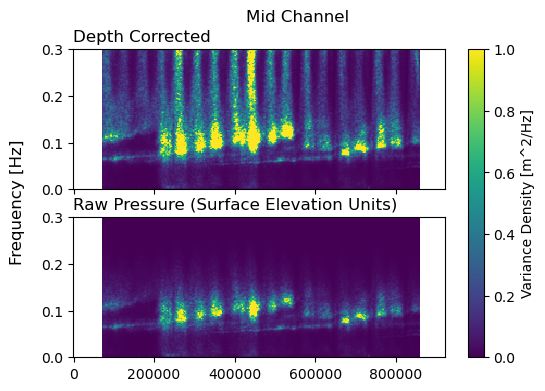

In [148]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6,4))
cf0 = axs[0].pcolormesh(record_t, freq, S_eta.T, vmin=0, vmax=1)
cf1 = axs[1].pcolormesh(record_t, freq, S_p.T, vmin=0, vmax=1)
plt.ylim(0, 0.3)
axs[0].set_title("Depth Corrected", loc='left')
axs[1].set_title("Raw Pressure (Surface Elevation Units)", loc='left')
fig.supylabel("Frequency [Hz]")
cb = plt.colorbar(cf0, ax=axs)
cb.ax.set_ylabel("Variance Density [m^2/Hz]")
fig.suptitle("Mid Channel")
plt.show()

In [149]:
mc = scipy.io.loadmat('/home/cassandra/Willapa/2025-experiment-1/anchorRBRs/MCanchor_RBR_17-26Jun2025_16-Jun-2025_26-Jun-2025_depthcorrected.mat')

In [150]:
mc.keys()

dict_keys(['__header__', '__version__', '__globals__', 'RBRcorr'])

In [151]:
i = 0
jim_times = []
jim_spectra = []

for i in range(len(mc['RBRcorr'][0])):
    mtime = mc['RBRcorr'][0][i][0][0][0]
    mspec = mc['RBRcorr'][0][i][8][0][0][0][:,0]
    mfreq = mc['RBRcorr'][0][i][8][0][0][1][:,0]

    jim_times.append(mtime)
    jim_spectra.append(mspec)

jim_times = np.array(jim_times)
jim_spectra = np.array(jim_spectra)
mfreq = np.array(mfreq)

# Convert matlab datenum to datetime64
def matlab2datetime(matlab_datenum, round_to):
    t = pd.to_datetime(matlab_datenum - 719529, unit='D')
    # Solution isn't exact so this round cleans things up
    t_clean = t.round(freq=round_to)  # hour 'min',
    return t_clean

jim_times = matlab2datetime(jim_times, 's')
jtf = (jim_times - rbr.time[0].values).values.astype(float)/1e9

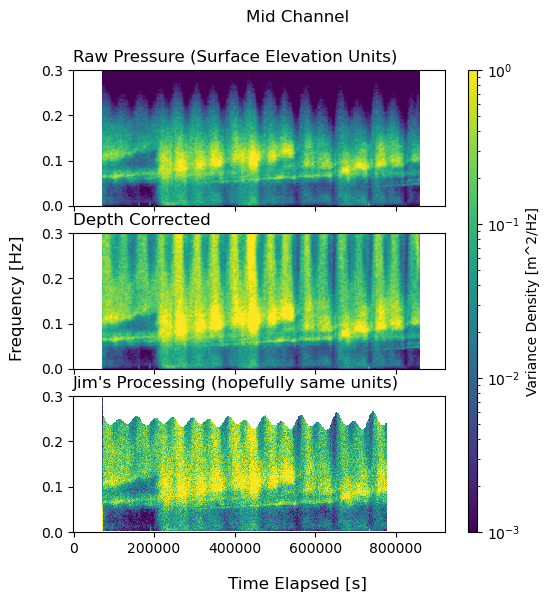

In [152]:
fig, axs = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(6,6))
cf0 = axs[0].pcolormesh(record_t, freq, S_p.T, vmin=1e-3, vmax=1, norm='log')
cf1 = axs[1].pcolormesh(record_t, freq, S_eta.T, vmin=1e-3, vmax=1, norm='log')
cf2 = axs[2].pcolormesh(jtf, mfreq, jim_spectra.T, vmin=1e-3, vmax=1, norm='log') 
plt.ylim(0, 0.3)
axs[0].set_title("Raw Pressure (Surface Elevation Units)", loc='left')
axs[1].set_title("Depth Corrected", loc='left')
axs[2].set_title("Jim's Processing (hopefully same units)", loc='left')
fig.supylabel("Frequency [Hz]")
cb = plt.colorbar(cf0, ax=axs, aspect=50)
cb.ax.set_ylabel("Variance Density [m^2/Hz]")
fig.suptitle("Mid Channel")
fig.supxlabel("Time Elapsed [s]")
plt.show()

In [155]:
is_ig = np.logical_and(freq >= 0.004, freq <= 0.04)
is_ss = np.logical_and(freq > 0.04, freq <= 0.3)

m_is_ig = np.logical_and(mfreq >= 0.004, mfreq <= 0.04)
m_is_ss = np.logical_and(mfreq > 0.04,   mfreq <= 0.3)

In [159]:
df = freq[1] - freq[0]
dmf = mfreq[1] - mfreq[0]

In [168]:
H_ss_raw = np.array([4*np.sqrt(np.nansum(s[is_ss])*df) for s in S_p])
H_ig_raw = np.array([4*np.sqrt(np.nansum(s[is_ig])*df) for s in S_p])

H_ss_sur = np.array([4*np.sqrt(np.nansum(s[is_ss])*df) for s in S_eta])
H_ig_sur = np.array([4*np.sqrt(np.nansum(s[is_ig])*df) for s in S_eta])

H_ss_jim = np.array([4*np.sqrt(np.nansum(s[m_is_ss])*dmf) for s in jim_spectra])
H_ig_jim = np.array([4*np.sqrt(np.nansum(s[m_is_ig])*dmf) for s in jim_spectra])

In [170]:
# despike the IG signal in Jim's processing, there's an anomaly at the very beginning
H_ig_jim[0] = np.nan

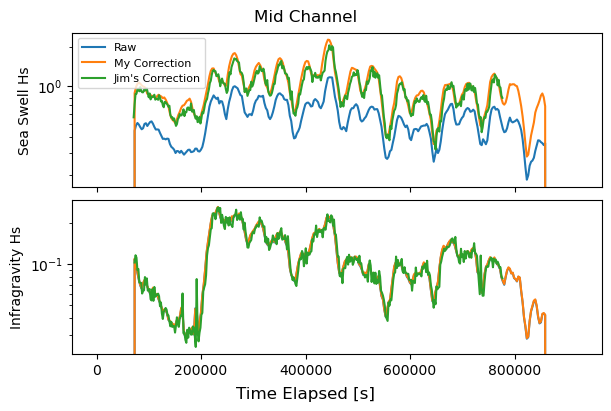

In [175]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6,4), constrained_layout=True)
axs[0].plot(record_t, H_ss_raw, label='Raw')
axs[0].plot(record_t, H_ss_sur, label='My Correction')
axs[0].plot(jtf, H_ss_jim, label="Jim's Correction")
axs[0].legend(fontsize=8, loc=2)
axs[0].set_ylabel("Sea Swell Hs")
axs[1].plot(record_t, H_ig_raw, label='Raw')
axs[1].plot(record_t, H_ig_sur, label='My Correction')
axs[1].plot(jtf, H_ig_jim, label="Jim's Correction")
axs[1].set_ylabel("Infragravity Hs")
axs[0].set_yscale('log')
axs[1].set_yscale('log')
fig.suptitle("Mid Channel")
fig.supxlabel("Time Elapsed [s]")
plt.show()